In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from collections import defaultdict
import networkx as nx
import time


In [2]:
x1 = pd.read_csv('data/X1.csv')  
y1 = pd.read_csv('data/Y1.csv')   

In [3]:
def evaluate_pairs(pred_pairs, ground_truth_clusters):
    true_pairs = set()
    for cluster in ground_truth_clusters:
        for a in range(len(cluster)):
            for b in range(a+1, len(cluster)):
                i,j = cluster[a], cluster[b]
                true_pairs.add((min(i,j), max(i,j)))

    all_pairs = pred_pairs.union(true_pairs)
    y_true = [1 if p in true_pairs else 0 for p in all_pairs]
    y_pred = [1 if p in pred_pairs  else 0 for p in all_pairs]

    p, r, f1, _ = precision_recall_fscore_support(
        y_true, y_pred,
        average='binary',
        zero_division=0
    )
    return {'precision': p, 'recall': r, 'f_score': f1}

In [4]:
class EntityResolutionPipeline:
    def __init__(self):
        self.data = None
        self.cleaned_data = None
        self.blocks = defaultdict(list)
        self.candidate_pairs = set()
        self.matches = set()
        self.clusters = []
        
    def set_data(self, data):
        self.data = data.copy()
        self.cleaned_data = data.copy()
        self.cleaned_data['cleaned_title'] = self.cleaned_data['title']
        return self.data
    
    def clean_data(self):
        self.cleaned_data = self.data.copy()
        extra_words = {
            'bundle', 'warranty', 'deal', 'offers?', 'shipping',
            'windows', 'win(?:\d+)?', 'pro', 'home', 'ultimate',
            'beats', 'audio'
        } 
        common_words = [
            'vology', '-', '/', '"', 'hdd', 'ssd', 'windows ', 'windows',
            'laptop', 'new', 'sale', 'core', 'buy', 'computers', 'computer', 
            'computers', 'com'
        ]
        def clean_title(title):
            title = title.lower()
            title = re.sub(r'[!@#$%^&*()_+={}\[\]|\\:;<>?,./"]', ' ', title)
            title_tokens = title.split()
            title_tokens = [token for token in title_tokens if token not in ENGLISH_STOP_WORDS]
            title = ' '.join(title_tokens)
            title = re.sub(r'(\d+)\s*gb', r'\1gb', title)  
            title = re.sub(r'(\d+)\s*tb', r'\1tb', title) 
            title = re.sub(r'core\s*i(\d)', r'corei\1', title)  
            title = re.sub(r'windows\s*(\d+)', r'windows\1', title) 
            title = re.sub(r'gigs', 'gb', title)
            
            for i in common_words:
                title = title.replace(i, '')

            for i in extra_words:
                title = title.replace(i, '')
            
            return title
        
        self.cleaned_data['cleaned_title'] = self.cleaned_data['title'].apply(clean_title)
        return self.cleaned_data
    
    def create_blocks(self):    
        self.blocks = defaultdict(list)
        
        for idx, row in self.cleaned_data.iterrows():
            tokens = row['cleaned_title'].split()
            for token in tokens:
                if len(token) > 2:  
                    self.blocks[token].append(row['id'])
        
        return self.blocks
    
    def filter_blocks(self, tau):
        filtered_blocks = {token: records for token, records in self.blocks.items() 
                          if len(records) < tau and len(records) > 1}       
        self.candidate_pairs = set()      
        for records in filtered_blocks.values():
            for i in range(len(records)):
                for j in range(i+1, len(records)):
                    self.candidate_pairs.add((records[i], records[j]))   
        return self.candidate_pairs
    
    def compute_jaccard_similarity(self, id1, id2):
        if not hasattr(self, '_id_to_row_index'):
            self._id_to_row_index = {row['id']: i for i, row in self.cleaned_data.iterrows()}
        try:
            idx1 = self._id_to_row_index[id1]
            idx2 = self._id_to_row_index[id2]
            
            tokens1 = set(self.cleaned_data.iloc[idx1]['cleaned_title'].split())
            tokens2 = set(self.cleaned_data.iloc[idx2]['cleaned_title'].split())
            
            intersection = len(tokens1.intersection(tokens2))
            union = len(tokens1.union(tokens2))
            
            return intersection / union if union > 0 else 0
        except (KeyError, IndexError):
            return 0

    def find_matches(self, alpha):
        self.matches = set()
        if not hasattr(self, '_id_to_row_index'):
            self._id_to_row_index = {row['id']: i for i, row in self.cleaned_data.iterrows()}
        
        for id1, id2 in self.candidate_pairs:
            similarity = self.compute_jaccard_similarity(id1, id2)
            if similarity > alpha:
                self.matches.add((min(id1, id2), max(id1, id2)))
        
        return self.matches
    
    def pivot_clustering(self):
        adj_list = defaultdict(list)
        all_ids = set()
        
        for id1, id2 in self.matches:
            adj_list[id1].append(id2)
            adj_list[id2].append(id1)
            all_ids.add(id1)
            all_ids.add(id2)
        
        remaining_nodes = set(all_ids)
        clusters = []
        
        while remaining_nodes:
            pivot = None
            max_degree = -1
            for node in remaining_nodes:
                degree = len(adj_list[node])
                if degree > max_degree:
                    max_degree = degree
                    pivot = node

            if pivot is None or max_degree == 0:
                if remaining_nodes:
                    pivot = next(iter(remaining_nodes))
                    clusters.append([pivot])
                    remaining_nodes.remove(pivot)
                continue
            
            neighbors = adj_list[pivot]
            cluster = [pivot] + neighbors
            clusters.append(cluster)

            for node in cluster:
                if node in remaining_nodes:
                    remaining_nodes.remove(node)
        
        self.clusters = clusters
        return self.clusters

In [5]:
data = x1
truth_labels = y1

edges = [(row['lid'], row['rid']) for _, row in truth_labels.iterrows()]
ground_truth_clusters = []
used_ids = set()

for id1, id2 in edges:
    found_cluster = None
    for cluster in ground_truth_clusters:
        if id1 in cluster or id2 in cluster:
            found_cluster = cluster
            break
    
    if found_cluster:
        found_cluster.add(id1)
        found_cluster.add(id2)
    else:
        ground_truth_clusters.append({id1, id2})
    
    used_ids.add(id1)
    used_ids.add(id2)

ground_truth_clusters = [list(cluster) for cluster in ground_truth_clusters]

pipeline = EntityResolutionPipeline()
pipeline.set_data(data)

,id,title
0,270345,BEST ASPIRE CUBE INTEL 6885 INTEL FRAME QUAD I...
1,163850,Panasonic Latitude 14 B5232 - Solid Duo! (BX80...
2,180242,Panasonic 667374-B21 Toshiba 2325 Pc AMD LED 2...
3,712728,64-bit t540p / n7110 wifi | us 8gb hd laptop n...
4,729116,dell google 1737 7000 chromebook i5 (67y2625) ...
...,...,...
1656,573419,"computer,7 : laptop for 500 vology ebay sony i..."
1657,294893,"hp d6f48us#aba pro intel hp 14"" intel core i7 ..."
1658,1040368,"Acer Aspire E1-572-34014G50Mnrr 15.6"" LED Note..."
1659,827382,"Dell 2000 HP 14"" - 6'' 640GB (Ice 500GB 4GB Bu..."


In [6]:
def plot_recall_vs_tau(data, ground_truth_clusters):
    """Plot recall of candidate pairs as a function of tau"""
    pipeline = EntityResolutionPipeline()
    pipeline.set_data(data)
    pipeline.clean_data()
    pipeline.create_blocks()
    
    tau_values = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    recalls = []
    
    for tau in tau_values:
        candidates = pipeline.filter_blocks(tau)
        metrics = evaluate_pairs(candidates, ground_truth_clusters)
        recalls.append(metrics['recall'])
    
    plt.figure(figsize=(10, 6))
    plt.plot(tau_values, recalls, marker='o', linestyle='-')
    plt.xlabel('τ (Block Size Threshold)')
    plt.ylabel('Recall')
    plt.title('Recall of Candidate Pairs vs. τ')
    plt.grid(True)
    plt.savefig('recall_vs_tau.png')
    plt.show()
    
    return pd.DataFrame({'tau': tau_values, 'recall': recalls})

In [7]:
def plot_metrics_vs_alpha(data, ground_truth_clusters, fixed_tau=50):
    """Plot precision, recall, and F-measure vs alpha with a fixed tau value"""
    pipeline = EntityResolutionPipeline()
    pipeline.set_data(data)
    pipeline.clean_data()
    pipeline.create_blocks()
    pipeline.filter_blocks(fixed_tau)
    
    alpha_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    precisions = []
    recalls = []
    f_scores = []
    
    for alpha in alpha_values:
        matches = pipeline.find_matches(alpha)
        metrics = evaluate_pairs(matches, ground_truth_clusters)
        precisions.append(metrics['precision'])
        recalls.append(metrics['recall'])
        f_scores.append(metrics['f_score'])
    
    plt.figure(figsize=(10, 6))
    plt.plot(alpha_values, precisions, marker='o', linestyle='-', label='Precision')
    plt.plot(alpha_values, recalls, marker='s', linestyle='-', label='Recall')
    plt.plot(alpha_values, f_scores, marker='^', linestyle='-', label='F-measure')
    plt.xlabel('α (Similarity Threshold)')
    plt.ylabel('Score')
    plt.title(f'Precision, Recall, and F-measure vs. α (τ={fixed_tau})')
    plt.grid(True)
    plt.legend()
    plt.savefig('metrics_vs_alpha.png')
    plt.show()
    
    return pd.DataFrame({
        'alpha': alpha_values,
        'precision': precisions,
        'recall': recalls,
        'f_score': f_scores
    })


--- Question 2a ---


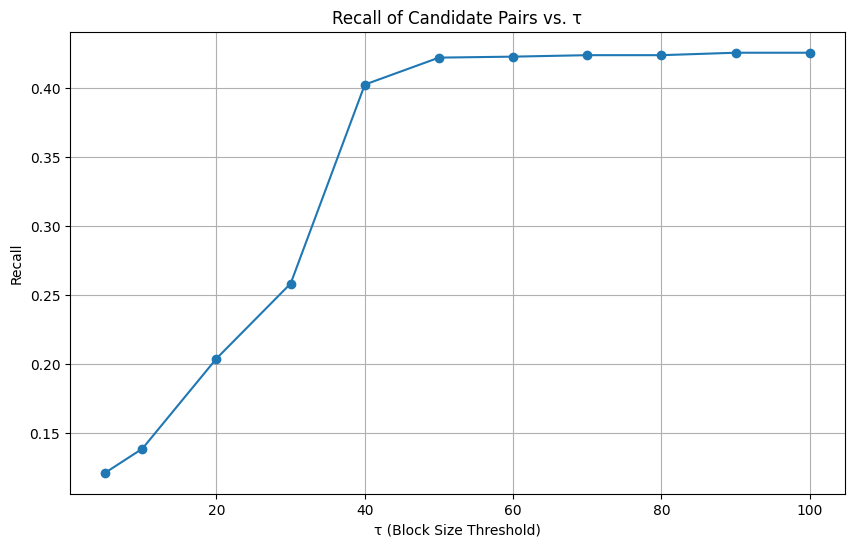

Generated plot of recall vs τ
Recall values:
    tau    recall
0     5  0.121180
1    10  0.138593
2    20  0.203980
3    30  0.258351
4    40  0.402630
5    50  0.422175
6    60  0.422886
7    70  0.423952
8    80  0.423952
9    90  0.425729
10  100  0.425729


In [8]:
print("\n--- Question 2a ---")
recall_data = plot_recall_vs_tau(data, ground_truth_clusters)
print("Generated plot of recall vs τ")
print("Recall values:")
print(recall_data)


--- Question 2b ---


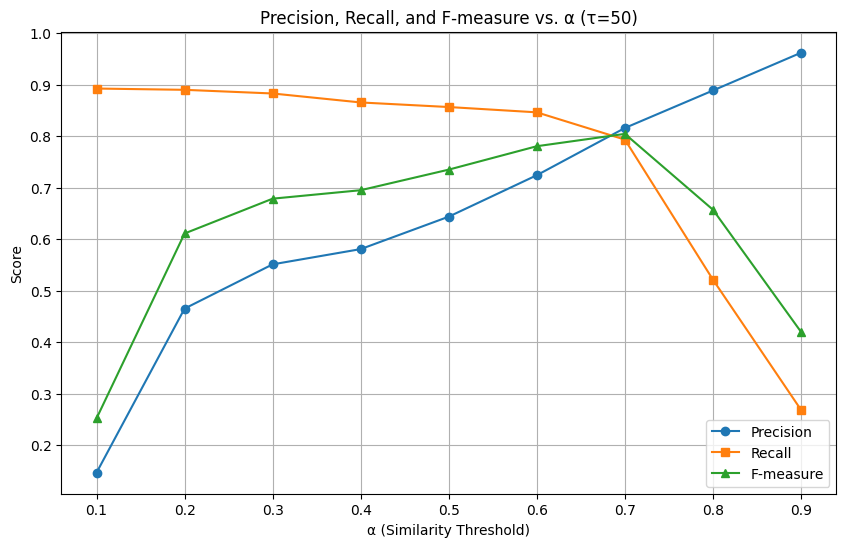

Generated plot of precision, recall, and F-measure vs α
Metrics values:
   alpha  precision    recall   f_score
0    0.1   0.146748  0.892324  0.252045
1    0.2   0.465255  0.889837  0.611030
2    0.3   0.551143  0.882729  0.678596
3    0.4   0.580730  0.865316  0.695019
4    0.5   0.643697  0.856432  0.734980
5    0.6   0.724148  0.846127  0.780400
6    0.7   0.815789  0.793177  0.804324
7    0.8   0.888552  0.521322  0.657111
8    0.9   0.961832  0.268657  0.420000


In [9]:
print("\n--- Question 2b ---")
metrics_data = plot_metrics_vs_alpha(data, ground_truth_clusters)
print("Generated plot of precision, recall, and F-measure vs α")
print("Metrics values:")
print(metrics_data)

In [10]:
def run_pipeline(tau, alpha, clean_the_data =True):  
    blocks = defaultdict(list)
    candidate_pairs = set()
    matches = set()
    clusters = []
    tau = 50
    alpha = 0.7
    
    start_time = time.time()
    pipeline = EntityResolutionPipeline()
    data = pd.read_csv('data/X1.csv')
    pipeline.set_data(data)
    ground_truth = pd.read_csv('data/Y1.csv').values.tolist()
        
    if clean_the_data:
        data = pipeline.clean_data()

    # Blocking
    blocking_start = time.time()
    blocks = pipeline.create_blocks()
    candidates = pipeline.filter_blocks(tau)
    blocking_time = time.time() - blocking_start
    print(f"Blocking completed in {blocking_time:.2f} seconds, generated {len(candidates)} candidate pairs")
    
    # Evaluate blocking
    block_metrics = evaluate_pairs(candidates, ground_truth)
    print(f"  → Blocking metrics:  precision={block_metrics['precision']:.3f},"
            f" recall={block_metrics['recall']:.3f},"
            f" F₁={block_metrics['f_score']:.3f}\n")
   
    # Pair matching
    matching_start = time.time()
    matches = pipeline.find_matches(alpha)
    matching_time = time.time() - matching_start
    print(f"Pair matching completed in {matching_time:.2f} seconds, found {len(matches)} matches")
    
    match_metrics = evaluate_pairs(matches, ground_truth)
    print(f"  → Pair‐matching metrics:  precision={match_metrics['precision']:.3f},"
            f" recall={match_metrics['recall']:.3f},"
            f" F₁={match_metrics['f_score']:.3f}\n")
    
    # Clustering
    clustering_start = time.time()
    edges = [(row['lid'], row['rid']) for _, row in truth_labels.iterrows()]
    ground_truth_clusters = []
    used_ids = set()
    for id1, id2 in edges:
        found_cluster = None
        for cluster in ground_truth_clusters:
            if id1 in cluster or id2 in cluster:
                found_cluster = cluster
                break
        
        if found_cluster:
            found_cluster.add(id1)
            found_cluster.add(id2)
        else:
            ground_truth_clusters.append({id1, id2})
        
        used_ids.add(id1)
        used_ids.add(id2)

    ground_truth_clusters = [list(cluster) for cluster in ground_truth_clusters]
    clusters = pipeline.pivot_clustering()
    print(f"Created {len(clusters)} clusters")
    print("Sample clusters:")
    for i, cluster in enumerate(clusters[:5]):
        for record_id in cluster[:3]:
            record_title = pipeline.cleaned_data.loc[pipeline.cleaned_data['id'] == record_id, 'cleaned_title'].iloc[0]
        if len(cluster) > 3:
            print(f"  ... and {len(cluster) - 3} more records")

    clustering_time = time.time() - clustering_start
    print(f"Clustering completed in {clustering_time:.2f} seconds, found {len(clusters)} clusters")
    
    # Evaluate clustering
    cluster_pairs = set()
    for cluster in clusters:
        for i in range(len(cluster)):
            for j in range(i+1, len(cluster)):
                id1, id2 = cluster[i], cluster[j]
                cluster_pairs.add((min(id1, id2), max(id1, id2)))

    cluster_metrics = evaluate_pairs(cluster_pairs, ground_truth_clusters)

    print(f"  → Clustering metrics:  precision={cluster_metrics['precision']:.3f},"
                  f" recall={cluster_metrics['recall']:.3f},"
                  f" F₁={cluster_metrics['f_score']:.3f}\n")
    
    total_time = time.time() - start_time
    print(f"Total execution time: {total_time:.2f} seconds")
    
    return {
        'blocking': {
            'precision': block_metrics['precision'],
            'recall': block_metrics['recall'],
            'f1': block_metrics['f_score'],
            'time': blocking_time,
            'candidates': len(candidate_pairs)
        },
        'matching': {
            'precision': match_metrics['precision'],
            'recall': match_metrics['recall'],
            'f1': match_metrics['f_score'],
            'time': matching_time,
            'matches': len(matches)
        },
        'clustering': {
            'precision': cluster_metrics['precision'],
            'recall': cluster_metrics['recall'],
            'f1': cluster_metrics['f_score'],
            'time': clustering_time,
            'clusters': len(clusters)
        },
        'total_time': total_time
    }

In [11]:
def compare_cleaning(tau, alpha):
    with_cleaning = run_pipeline(tau, alpha, True)
    without_cleaning = run_pipeline(tau, alpha, False)
    
    print("\nComparison:")
    print(f"With cleaning - Final F1: {with_cleaning['matching']['f1']:.4f}, Total time: {with_cleaning['total_time']:.2f}s")
    print(f"Without cleaning - Final F1: {without_cleaning['matching']['f1']:.4f}, Total time: {without_cleaning['total_time']:.2f}s")
    
    return with_cleaning, without_cleaning

In [12]:
# Question 2c and 2d
print("\n--- Question 2c & 2d ---")
best_results = run_pipeline(50, 0.7, True)
# print(best_results)

with_cleaning, without_cleaning = compare_cleaning(50, .7)
print("With cleaning:", with_cleaning)
print("Without cleaning:", without_cleaning)


--- Question 2c & 2d ---
Blocking completed in 0.08 seconds, generated 47471 candidate pairs
  → Blocking metrics:  precision=0.025, recall=0.422, F₁=0.047

Pair matching completed in 2.49 seconds, found 2736 matches
  → Pair‐matching metrics:  precision=0.816, recall=0.793, F₁=0.804

Created 709 clusters
Sample clusters:
  ... and 34 more records
  ... and 26 more records
  ... and 26 more records
  ... and 25 more records
  ... and 18 more records
Clustering completed in 0.12 seconds, found 709 clusters
  → Clustering metrics:  precision=0.678, recall=0.822, F₁=0.743

Total execution time: 2.82 seconds
Blocking completed in 0.08 seconds, generated 47471 candidate pairs
  → Blocking metrics:  precision=0.025, recall=0.422, F₁=0.047

Pair matching completed in 2.97 seconds, found 2736 matches
  → Pair‐matching metrics:  precision=0.816, recall=0.793, F₁=0.804

Created 709 clusters
Sample clusters:
  ... and 34 more records
  ... and 26 more records
  ... and 26 more records
  ... and 